In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch

# import all the models from models module
from models import CNN3D

In [2]:
# Current Path
os.getcwd()

'c:\\Users\\ahmed\\Documents\\DeepLearningSummer\\Multimodal-Deep-Regression\\notebooks'

In [3]:
device = get_device()
x_dir, y_dir = get_base_tensor_directories(input_type='initial_1000')

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

You are using device: cuda


In [4]:
x_data = [torch.load(f) for f in x_files]
y_data = [torch.load(f) for f in y_files]

In [5]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 214, 1024, 576])
torch.Size([3, 282, 1024, 576])
4
1


In [6]:
[i.shape for i in x_data]

[torch.Size([3, 214, 1024, 576]),
 torch.Size([3, 471, 1024, 576]),
 torch.Size([3, 213, 1024, 576]),
 torch.Size([3, 166, 1024, 576]),
 torch.Size([3, 282, 1024, 576])]

In [7]:
# Create Batches with DataLoaders
batch_size = 1
train_loader = list(zip(x_train, y_train)) #TensorDataset(x_train, y_train)
val_loader = list(zip(x_val, y_val)) #TensorDataset(x_val, y_val)
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

In [8]:
model = CNN3D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=0.01)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 20

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=True)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=True)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


Total parameters: 603,981,089


Forward pass on batch with size: torch.Size([1, 3, 471, 1024, 576])
Model Output (shape: torch.Size([1, 1])): tensor([[-18.1845]], grad_fn=<AddmmBackward0>)
Target (shape: torch.Size([1, 1])): tensor([[48000.]])


Forward pass on batch with size: torch.Size([1, 3, 214, 1024, 576])
Model Output (shape: torch.Size([1, 1])): tensor([[6677336.5000]], grad_fn=<AddmmBackward0>)
Target (shape: torch.Size([1, 1])): tensor([[202900.]])


Forward pass on batch with size: torch.Size([1, 3, 213, 1024, 576])
Model Output (shape: torch.Size([1, 1])): tensor([[1658926.]], grad_fn=<AddmmBackward0>)
Target (shape: torch.Size([1, 1])): tensor([[376400.]])


Forward pass on batch with size: torch.Size([1, 3, 166, 1024, 576])
Model Output (shape: torch.Size([1, 1])): tensor([[-2068093.5000]], grad_fn=<AddmmBackward0>)
Target (shape: torch.Size([1, 1])): tensor([[22000.]])


Evaluating on batch with size: torch.Size([1, 3, 282, 1024, 576])
Model Output (shape: torch.Size([1,

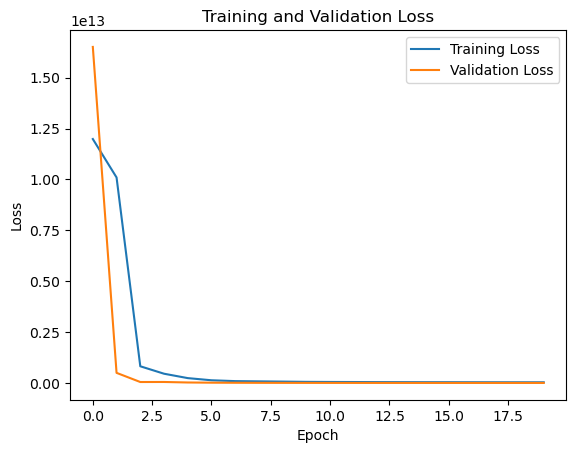

In [9]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

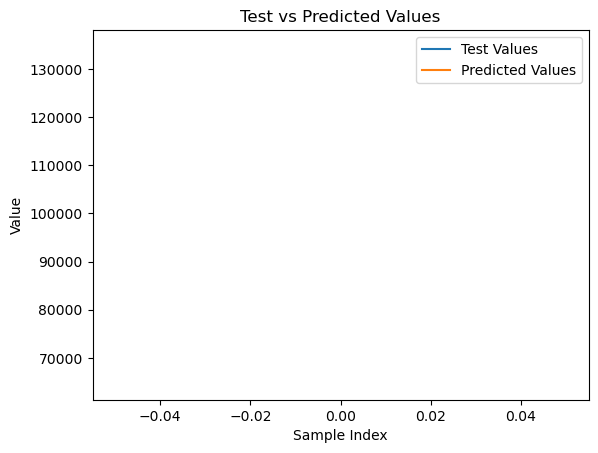

In [11]:
import matplotlib.pyplot as plt

plt.plot(val_values, label='Test Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [12]:
val_values, predicted_values

([64800.0], [[134585.71875]])